# Part 1: Tabular Q-Learning

In this part of the assignment you will familiarize yourself with the [Gymnasium API](https://gymnasium.farama.org/) for reinforcement learning and implement a tabular Q-learning agent to learn a behavioral policy in the simple [Taxi environment](https://gymnasium.farama.org/environments/toy_text/taxi/). This is intended as a warmup on a relatively small and simple task, preparing for a more challenging deep reinforcement learning task in part 2.

**Learning objectives.** You will:
1. Install and study the standard Gymnasium API for representing a reinforcement learning environment simulation
2. Implement the tabular Q-learning algorithm with epsilon greedy action selection
3. Train an agent / compute an optimal q function and policy, experimenting with various hyperparameters like the learning rate and exploration decay
4. Evaluate the learning curve of average episodic return over training

We will use the [Gymnasium API](https://gymnasium.farama.org/) for our reinforcement learning environments. First you should run one of the following to install the necessary packages (either using `pip` or `conda` depending on your preferred Python package manager).

In [1]:
#!pip install "gymnasium[all]"
!pip install gymnasium

In [2]:
#!conda install -c conda-forge gymnasium-all
!conda install -c conda-forge gymnasium

/bin/bash: line 1: conda: command not found


If you have trouble with the above installation, try the simpler `pip install gymnasium` or `conda install -c conda-forge gymnasium` command (which does not install all of the dependencies that may only be needed for specific environments).

You can check that the installation was successful by running the following code. The code attempts to import the gymnasium module, create a simple [Taxi environment](https://gymnasium.farama.org/environments/toy_text/taxi/), and then execute random actions in the environment.

The environment is set to `render_mode="human"`, meaning you should see a visualization of the environment with the agent taking random actions. **Be aware that the visualization can be unstable on some platforms** - It is possible your Python Kernel will crash after closing the visualization.

The **visualization itself is optional** -- if it crashes your Python kernel you can still complete this assignment without using `render_mode = "human"`.

In [3]:
import gymnasium as gym

# Initialise the environment
env = gym.make("Taxi-v3", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset()
print(env.render())
for _ in range(100):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

None


Next you should review the [Gymnasium Basic Usage Documentation](https://gymnasium.farama.org/introduction/basic_usage/) (through the Action and observation spaces section; you do not need to worry about the section on Modifying the environment). It may also be helpful to review or refer to the [Environment API documentation here](https://gymnasium.farama.org/api/env/).

## Task 1

Your first task is to define a **tabular** Q-learning agent for the simple [Taxi Environment](https://gymnasium.farama.org/environments/toy_text/taxi/). You should refer to the environment documentation to understand the state/observation space, action space, and reward function.

**Implementation Details:**

1. **Q-table structure:** You can use a 2D NumPy array with dimensions `[num_states, num_actions]`. You can get these dimensions from the environment:
   - `env.observation_space.n` gives the number of states
   - `env.action_space.n` gives the number of actions

2. **Epsilon greedy action selection:** With probability `epsilon`, select a random action using `env.action_space.sample()`. Otherwise, select the action with maximum Q-value.

3. **Q-learning update rule:** $Q(s,a) ← Q(s,a) + \alpha [r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$ where:
   - $\alpha$ is the learning rate
   - $\gamma$ is the discount factor
   - If the episode terminated, the target is just `r` (no future value)

4. **Epsilon decay:** After each update, decay epsilon by the multiplicative factor unless already at the final/minimum value.

**Helpful documentation:**
- [`np.ones()`](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) - Initialize a 2D NumPy array prefilled with 1s.
- [`np.argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) Gives the index of the maximum value in an array.
- [`np.random.rand()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html) Gives random real numbers between 0 and 1.

Your agent `class` should implement at least the following three methods:
1. The constructor, `__init__()`, should store any relevant hyperparameters as instance variables and initialize a Q table, along with any other auxiliary instance variables you may choose to include.
2. The `action_select` method which should implement `epsilon` greedy action selection (`epsilon` should be an instance variable kept track of by the agent object).
3. The `update` method should take an environment experience (previous state, action taken, reward received, new state, and whether the episode terminated) as input and should perform a Q learning update on the Q table.

You are welcome but not required to add additional helper methods.

In [4]:
import gymnasium as gym
import numpy as np

class TaxiAgent:
    """
    Implements a tabular q learning agent for the taxi
    environment with discrete states and actions.
    """
    def __init__(self, env, lr=0.5, discount=0.99,
                 epsilon_init=1.0, epsilon_final=0.05,
                 epsilon_decay=0.99, q_init=0.0):
        """
        Initialize the Q-learning agent.

        Args:
            env: Gymnasium environment
            lr: Learning rate for Q-updates
            discount: Discount factor for future rewards
            epsilon_init: Initial exploration probability
            epsilon_final: Minimum exploration probability
            epsilon_decay: Multiplicative decay factor for epsilon
            q_init: Value to initialize q table entries
        """
        # TODO: Implement constructor
        self.env = env
        self.lr = lr
        self.discount = discount
        self.epsilon_init = epsilon_init
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay
        self.q_init = q_init
        self.epsilon = self.epsilon_init
        self.Q = np.ones((self.env.observation_space.n, self.env.action_space.n)) * self.q_init

    def action_select(self, s):
        """
        Epsilon-greedy action selection.

        Args:
            s: Current state (integer)

        Returns:
            action: Selected action (integer)
        """
        # TODO: Implement epsilon-greedy action selection
        action = None
        if np.random.rand() < self.epsilon:
          action = self.env.action_space.sample()
          return action
        action = np.argmax(self.Q[s])
        return action

    def update(self, s_old, a, r, s_new, terminated):
        """
        Perform Q-learning update.

        Args:
            s_old: Previous state
            a: Action taken
            r: Reward received
            s_new: New state
            terminated: Whether episode ended
        """
        # TODO: Implement Q-learning update step
        target = r
        if not terminated:
          target = r + self.discount * np.max(self.Q[s_new])
        self.Q[s_old, a] += self.lr * (target - self.Q[s_old, a])
        self.epsilon = max(self.epsilon_final, self.epsilon * self.epsilon_decay)

## Task 2

Now that you have defined your learning agent, implement training over several episodes of experience with the environment. Your goal is to learn an optimal q function and corresponding policy (in the Taxi environment, that just implies efficiently picking up and delivering passengers to their appropriate destinations).

You can modify hyperparameters for the `TaxiAgent` or the number of episodes of training as needed, but the default values have been selected to be reasonable for this task.

**What to Expect.** You should be able to learn a policy that achieves an **average/expected episode return (cumulative reward) of approximately 0 to 10** (because the agent receives 20 reward for a correct dropoff, and -1 for each timestep, and it will require 10-20 timesteps on average to complete a pickup and dropoff). You should be able to learn such a policy in several hundred to a few thousand episodes.

Training should be very quick on this environment and should not require GPU acceleration.

In [5]:
def train(agent, env, n_episodes=1000, print_every=100):
    """
    Train a Q-learning agent.

    Args:
        agent: TaxiAgent instance to train
        env: Gymnasium environment (should be wrapped with RecordEpisodeStatistics)
        n_episodes: Number of episodes to train for
        print_every: Print progress every N episodes (set to None to disable printing)

    Returns:
        agent: The trained agent
        env: The environment with recorded statistics
    """
    for episode in range(n_episodes):
        state, info = env.reset()
        episode_over = False

        while not episode_over:
            # TODO: Implement training loop
            a = agent.action_select(state)
            s_new, r, terminated, truncated, info = env.step(a)
            episode_over = terminated or truncated
            agent.update(state, a, r, s_new, episode_over)
            state = s_new

        # Optional: Print progress
        #if print_every and episode % print_every == 0:
            # TODO: Print average return over last print_every episodes

    return agent, env

In [6]:
# Initialise the environment
import gymnasium as gym
import numpy as np

env = gym.make("Taxi-v3")

# Can adjust n_episodes as needed for training
n_episodes = 1000

# Wrapper saves episode information necessary for later evaluation in task 3
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

# Can adjust agent hyperparameters as needed
agent = TaxiAgent(env)

# Train the agent
agent, env = train(agent, env, n_episodes=n_episodes, print_every=100)

print(f"\nTraining complete!")
print(f"Final average return (last 100 episodes): {np.mean(list(env.return_queue)[-100:]):.2f}")


Training complete!
Final average return (last 100 episodes): 4.89


When you are finished training, you can use the `visualize_learning_curves` function defined below to create two plots:
- one of the moving average episode return over the course of training,
- and another of the moving average episode length over the course of training.

A `smoothing` parameter to the function determines how many episodes to average over. That is, the default of `smoothing=10` means that each point in the resulting figure is the average of ten episodes. This has the visual effect of *smoothing* out the appearance of the plot, which can make the overall trend easier to visualize even if individual episodes vary significantly.

Run to the next code  create visualizations of your learning curves. You should see improving performance on average episode return converging toward approximately zero.

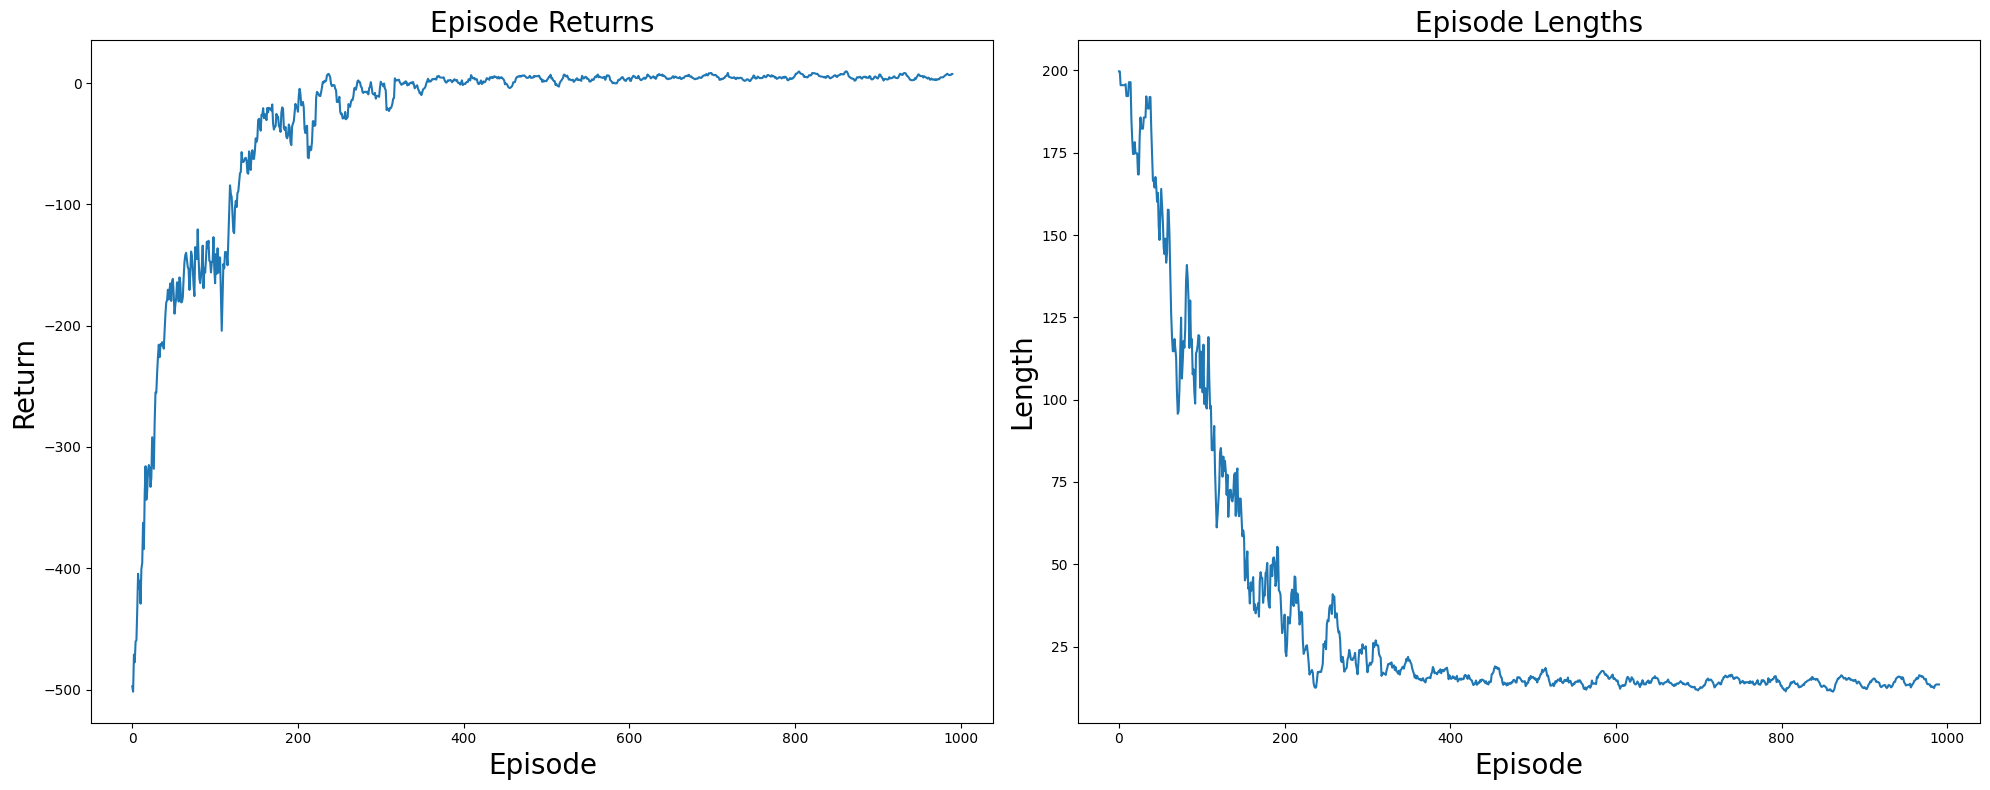

In [7]:
# Run, but you do not need to modify this code
import numpy as np
from matplotlib import pyplot as plt

def visualize_learning_curves(env, smoothing=10):
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(np.convolve(env.return_queue, np.ones(smoothing), 'valid') / smoothing)
    axs[0].set_title("Episode Returns", fontsize=20)
    axs[0].set_xlabel("Episode", fontsize=20)
    axs[0].set_ylabel("Return", fontsize=20)

    axs[1].plot(np.convolve(env.length_queue, np.ones(smoothing), 'valid') / smoothing)
    axs[1].set_title("Episode Lengths", fontsize=20)
    axs[1].set_xlabel("Episode", fontsize=20)
    axs[1].set_ylabel("Length", fontsize=20)

    plt.tight_layout()
    plt.show()

visualize_learning_curves(env, smoothing=10)

**Optional Qualitative Visualization.** The above evaluation of the learning curve was purely quantitative. While you are not required, you are invited and encouraged to qualitatively evaluate your learned policy/agent visually below.

To do so:
1. Render the environment in `"human"` mode as shown below. This should render the visualization of the environment.
2. Write a standard environment loop over several episodes (but far fewer than used for training, perhaps just 5 or so), and use the trained agent for action selection.
3. For this evaluation purpose, you are welcome to set `epsilon` to a lower value or even 0, and you do not need to perform learning updates.

**Note:** If you cannot visualize (e.g., running on a server without a display), you can use `gym.make("Taxi-v3", render_mode="ansi")` to print the visualization output as text. Then use `print(env.render())` to see the environment state.

**Be aware that the visualization can be unstable on some platforms** - It is possible your Python Kernel will crash after closing the visualization. This part is optional and not required.


In [8]:
# optional todo: environment loop to visualize learned policy
#env = gym.make("Taxi-v3", render_mode="human")
env = gym.make("Taxi-v3", render_mode="ansi")
env.reset()
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




## Task 3

Answer the following reflection and analysis questions.

**Question 1.** The visualization of your results from Task 2 should show a learning curve with average returns converging to near 0. However, the average returns in the first episodes are likely very negative, likely even less than -200 which is the return you would expect for a `TaxiAgent` that simply moves around randomly. Review the [Taxi environment documentation](https://gymnasium.farama.org/environments/toy_text/taxi/) and explain why the agent may receive returns even less than -200 early in training, referencing the implementation of the Q-learning algorithm.

**TODO: Answer 1:** So pretty much at the start of the training, the agen does not know which actions are considered good since all Q-values are the same, so it would move randomly or make repeated moves. And since the inital epsilon is high, the agent would keep exploring and would often take long or incorrect actions that leads to extra penalties. So with all of that, it is probably the reasons why we see low early returns from the Task 2 visualization as we see the returns drop below -200.


**Question 2.** In addition to the learning curve for average returns in Task 2, you should also see a visualization of how the average episode lengths are (likely) decreasing over the course of training. To what average episode length do you observe convergence, and why is that expected given the [Taxi environment documentation](https://gymnasium.farama.org/environments/toy_text/taxi/) and your implementation?

**TODO: Answer 2:** Looking at the visualization from task 2, I can see that the average episode length goes down and then eventually stabilizes around 10 and 20 steps as training continues. I say that the episode length decreases is because the agent learns the quickest route to pick up passengers and drop them off efficently. And shorter episodes would mean that the agent would make fewer unnecessary moves which would lead to higher returns.


**Question 3.** In the [Taxi environment documentation](https://gymnasium.farama.org/environments/toy_text/taxi/) it is specified that the agent receives a $-1$ immediate reward signal per step, if no other rewards are triggered. Explain how this reward function encourages early exploration.

For concreteness, suppose we initialize the Q-table to all 0s and then run Q-learning as implemented above. Why does this $-1$ per step reward function incentivize the agent to try unexplored states and actions? Reference the update step and action selection and be specific.

**TODO: Answer 3:** I be referencing the Q-learning update rule: $Q(s,a) ← Q(s,a) + \alpha [r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$. So when every action starts with a Q-value, taking a step would give a reward of -1 and would make the actions's Q-value negative through the update rule while unexplored actions would stay at 0. And during exploitation, the agent would use argmax so that it would prefer those unexplored actions over the negative actions. And over time, the -1 reward would keep spreading through the Q-table until the agent learns which actions would lead to better paths and higher rewards.